In [2]:
# !pip install pandas pyarrow tqdm matplotlib seaborn networkx
import os, json, gc, re, sys, warnings
from datetime import datetime
from pathlib import Path
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx          # for quick‑n‑dirty network EDA


In [3]:
RAW_PATH      = "/Users/vidur/Desktop/DSM/DSM_FinalProject/data/Yelp JSON/yelp_dataset/yelp_academic_dataset_user.json"       
USER_PQ       = "/Users/vidur/Desktop/DSM/DSM_FinalProject/data/users_clean.parquet"
EDGES_PQ      = "/Users/vidur/Desktop/DSM/DSM_FinalProject/data/friend_edges.parquet"
ERR_LOG       = "user_parse_errors.csv"

CHUNKSIZE     = 200_000     
DATE_RANGE    = ("2004-01-01", pd.Timestamp.today().normalize())

def safe_int(x):
    """Return int or NaN."""
    try:
        xi = int(x)
        return xi if xi >= 0 else np.nan
    except:
        return np.nan

def norm_list(val):
    """Turn '', None, list, or str of comma‑sep IDs into a clean list."""
    if val in (None, "", [], np.nan):
        return []
    if isinstance(val, list):
        return val
    if isinstance(val, str):
        # friends sometimes delivered as 'id1, id2'
        return [v.strip() for v in val.split(",") if v.strip()]
    return []

def cast_user_dtypes(df):
    """Memory‑friendly column dtypes."""
    int_cols = [
        "review_count", "useful", "funny", "cool",
        "fans", "compliment_hot", "compliment_more", "compliment_profile",
        "compliment_cute", "compliment_list", "compliment_note",
        "compliment_plain", "compliment_cool", "compliment_funny",
        "compliment_writer", "compliment_photos"
    ]
    for c in int_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int32")
    df["average_stars"] = pd.to_numeric(df["average_stars"], errors="coerce").clip(0,5).astype("float32")
    return df


In [4]:
user_batches   = []
edge_batches   = []
error_records  = []

stats = {
    "rows_read":0,"bad_user_id":0,"bad_date":0,"bad_numeric":0,
    "edge_rows":0
}

reader = pd.read_json(RAW_PATH, lines=True, chunksize=CHUNKSIZE)

for chunk in tqdm(reader, desc="Cleaning chunks"):
    stats["rows_read"] += len(chunk)
    
    # ---------------- drop missing IDs --------------------------------------
    bad_id_mask = chunk["user_id"].isna()
    stats["bad_user_id"] += bad_id_mask.sum()
    chunk = chunk.loc[~bad_id_mask]
    
    # ---------------- normalize lists ---------------------------------------
    chunk["friends"] = chunk["friends"].apply(norm_list)
    chunk["elite"  ] = chunk["elite"  ].apply(norm_list)
    
    # ---------------- date parsing ------------------------------------------
    chunk["yelping_since"] = pd.to_datetime(
        chunk["yelping_since"], errors="coerce", format="%Y-%m-%d"
    )
    bad_date_mask = chunk["yelping_since"].isna()
    stats["bad_date"] += bad_date_mask.sum()
    # keep bad dates but they stay NaT so you can decide later
    
    # ---------------- numeric sanity ---------------------------------------
    num_cols = [
        "review_count","useful","funny","cool","fans","average_stars",
        "compliment_hot","compliment_more","compliment_profile",
        "compliment_cute","compliment_list","compliment_note",
        "compliment_plain","compliment_cool","compliment_funny",
        "compliment_writer","compliment_photos"
    ]
    for col in num_cols:
        chunk[col] = pd.to_numeric(chunk[col], errors="coerce")
    stats["bad_numeric"] += chunk[num_cols].isna().sum().sum()
    
    # clip stars to [0,5]
    chunk["average_stars"] = chunk["average_stars"].clip(0,5)
    
    # ---------------- friend edges exploder ---------------------------------
    edges = (
        chunk[["user_id","friends"]]
        .explode("friends")
        .dropna(subset=["friends"])
        .query("friends != user_id")              # drop self‑loops
        .rename(columns={"user_id":"src", "friends":"dst"})
    )
    stats["edge_rows"] += len(edges)
    edge_batches.append(edges)
    chunk = chunk.drop(columns="friends")        # save RAM
    
    # ---------------- dtypes & store ----------------------------------------
    chunk = cast_user_dtypes(chunk)
    user_batches.append(chunk)

# concat & write once
users_df  = pd.concat(user_batches, ignore_index=True)
edges_df  = pd.concat(edge_batches, ignore_index=True).drop_duplicates()

users_df.to_parquet(USER_PQ, index=False, compression="snappy")
edges_df.to_parquet(EDGES_PQ, index=False, compression="snappy")

# convert all values to native Python ints (or strings)
stats_native = {k: int(v) for k, v in stats.items()}
print("✅ done")
print(json.dumps(stats_native, indent=2))

print(f"Users  → {USER_PQ}\nEdges  → {EDGES_PQ}")


Cleaning chunks: 10it [01:20,  8.08s/it]


✅ done
{
  "rows_read": 1987897,
  "bad_user_id": 0,
  "bad_date": 1987897,
  "bad_numeric": 0,
  "edge_rows": 106104025
}
Users  → /Users/vidur/Desktop/DSM/DSM_FinalProject/data/users_clean.parquet
Edges  → /Users/vidur/Desktop/DSM/DSM_FinalProject/data/friend_edges.parquet


In [5]:
users  = pd.read_parquet(USER_PQ)
edges  = pd.read_parquet(EDGES_PQ)
print(users.shape, edges.shape)


(1987897, 21) (106104025, 2)


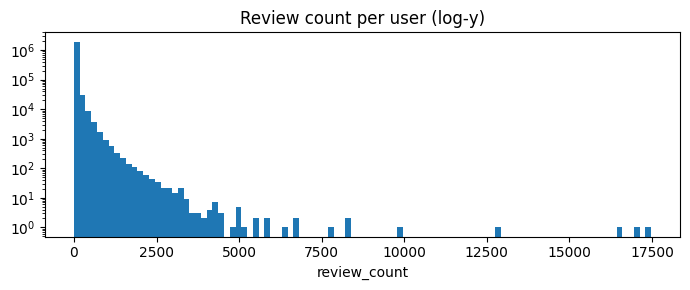

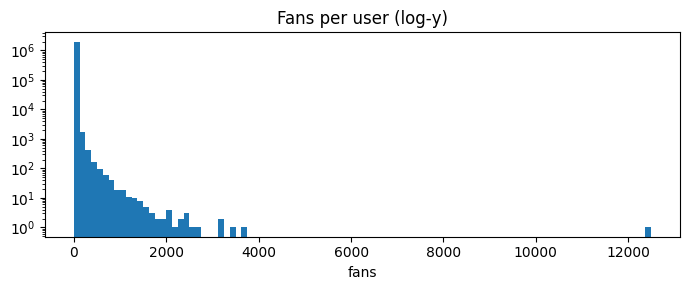

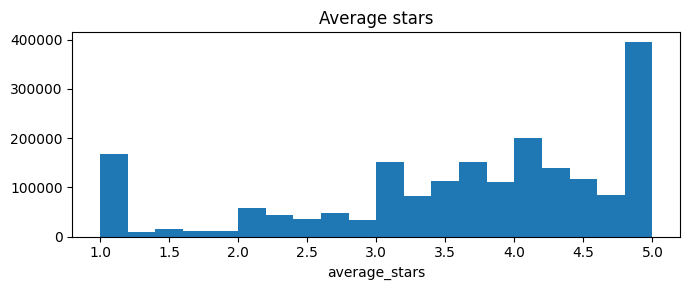

       review_count  average_stars       fans
count     1987897.0   1.987897e+06  1987897.0
mean      23.394409   3.630494e+00    1.46574
std       82.566992   1.183337e+00  18.130753
min             0.0   1.000000e+00        0.0
25%             2.0   3.000000e+00        0.0
50%             5.0   3.880000e+00        0.0
75%            17.0   4.560000e+00        0.0
90%            47.0   5.000000e+00        2.0
99%           311.0   5.000000e+00       26.0
max         17473.0   5.000000e+00    12497.0


In [6]:
def quick_hist(series, title, logy=False, bins=100):
    plt.figure(figsize=(7,3))
    plt.hist(series.dropna(), bins=bins, log=logy)
    plt.title(title); plt.xlabel(series.name); plt.tight_layout(); plt.show()

quick_hist(users["review_count"], "Review count per user (log‑y)", logy=True)
quick_hist(users["fans"],          "Fans per user (log‑y)", logy=True)
quick_hist(users["average_stars"], "Average stars", bins=20)

print(users[["review_count","average_stars","fans"]].describe(percentiles=[.25,.5,.75,.9,.99]))


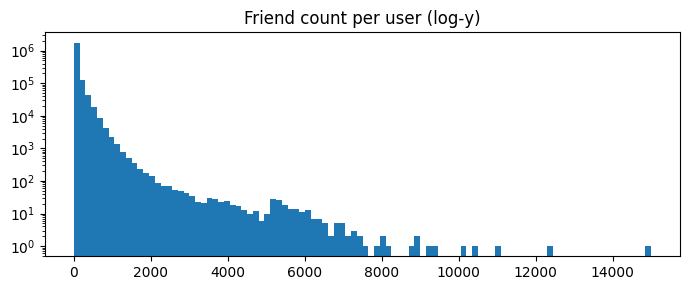

Friendless users : 0
Average friends  : 53.375011381374385
Graph with 7 nodes and 4 edges


/var/folders/b3/b3lpk8w51qj10znm_7bkftgr0000gn/T/ipykernel_44850/2838414062.py:14: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [7]:
# degree distribution
deg = edges.groupby("src").size()
quick_hist(deg, "Friend count per user (log‑y)", logy=True)

print("Friendless users :", (deg==0).sum())
print("Average friends  :", deg.mean())

# Tiny sample network plot (optional)
sample_nodes = deg.sample(2000, random_state=0).index
G = nx.from_pandas_edgelist(
    edges.query("src in @sample_nodes and dst in @sample_nodes").head(10000),
    "src","dst"
)
print(nx.info(G))


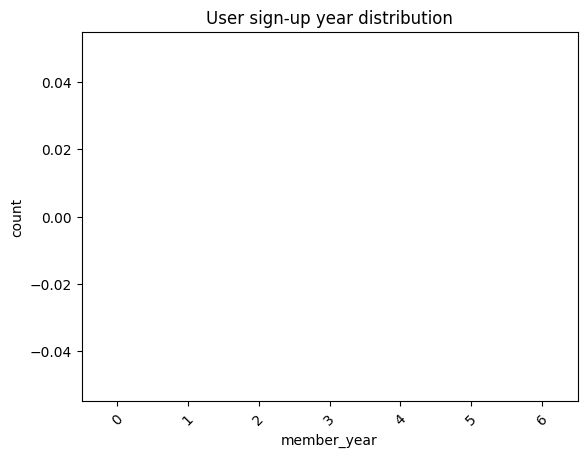

In [8]:
users["member_year"] = users["yelping_since"].dt.year
sns.countplot(data=users, x="member_year")
plt.xticks(rotation=45); plt.title("User sign‑up year distribution")
plt.show()


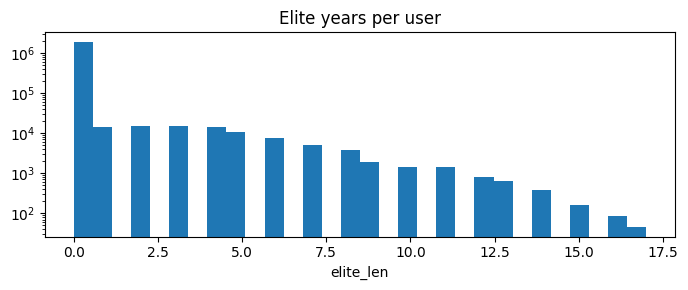

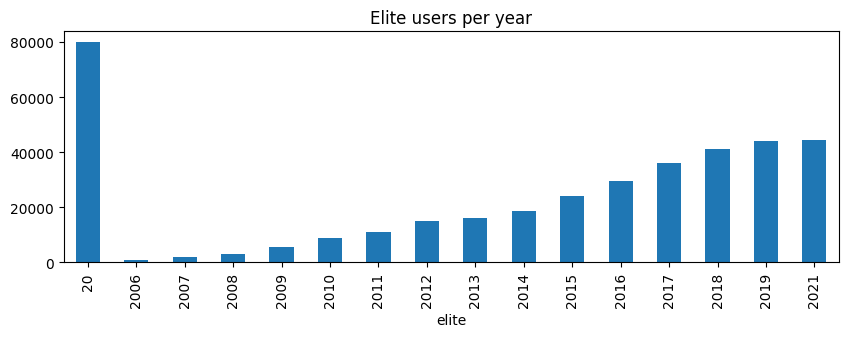

In [9]:
users["elite_len"] = users["elite"].apply(len)
quick_hist(users["elite_len"], "Elite years per user", logy=True, bins=30)
elite_years = (
    users["elite"].explode().dropna().value_counts().sort_index())
elite_years.plot(kind="bar", figsize=(10,3), title="Elite users per year")
plt.show()
